# How to break a neural network


We're going to use neural networks to make correct predictions!

THEN WE'RE GOING TO BREAK THEM.

In [100]:
# a bajillion imports
import shutil
import requests
import tempfile
import os
caffe_root = '/opt/caffe/'
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, caffe_root + 'python')

import caffe
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

If we're going to look at pictures of adorable dogs & pandas, we need a way to download them from the internet! This does that, and saves it to a png on our disk.

In [98]:
def get_png_image(url):
    fd, path = tempfile.mkstemp()
    tmpfile = os.fdopen(fd, "wb")
    response = requests.get(url, stream=True)
    shutil.copyfileobj(response.raw, tmpfile)
    !convert {path} {path}.png
    return path + ".png"

In [99]:
# Load the labels (so we know whether 242 means 'adorable puppy' or 'garbage can')
imagenet_labels_filename = caffe_root + '/data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !/opt/caffe/data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')


Set Caffe to CPU mode because who even knows how to set up a GPU (not me)

In [79]:
caffe.set_mode_cpu()
net = caffe.Net('/opt/caffe/models/bvlc_googlenet/deploy.prototxt',
                '/models/bvlc_googlenet.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
#transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

Let's start with a simple classification. We'll set a batch of 50 to demonstrate batch processing, even though we'll only be classifying one image. (Note that the batch size can also be changed on-the-fly.)

Feed in the image (with some preprocessing) and classify with a forward pass.

In [80]:
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/images/cat.jpg'))
out = net.forward()
print("Predicted class is #{}.".format(out['prob'][0].argmax()))

Predicted class is #282.


In [81]:
def classify(url):
    image = get_png_image(url)
    print image
    net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(image))
    out = net.forward()
    print("Predicted class is #{}.".format(out['prob'][0].argmax()))
    plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))
    # sort top k predictions from softmax output
    top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
    print labels[top_k]

What did the input look like?

Adorable, but was our classification correct?

/tmp/tmpWhadrs.png
Predicted class is #388.
[ 'n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca'
 'n02509815 lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens'
 'n02497673 Madagascar cat, ring-tailed lemur, Lemur catta'
 'n04399382 teddy, teddy bear' 'n02441942 weasel']


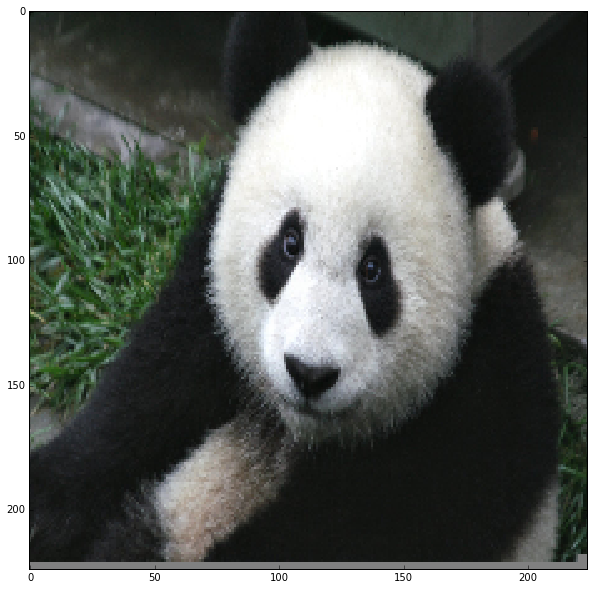

In [9]:
panda_url = 'https://upload.wikimedia.org/wikipedia/commons/c/cd/Panda_Cub_from_Wolong,_Sichuan,_China.JPG'
classify(panda_url)
panda_data = np.copy(net.blobs['data'].data)

In [26]:
labels

array(['n01440764 tench, Tinca tinca',
       'n01443537 goldfish, Carassius auratus',
       'n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
       'n01491361 tiger shark, Galeocerdo cuvieri',
       'n01494475 hammerhead, hammerhead shark',
       'n01496331 electric ray, crampfish, numbfish, torpedo',
       'n01498041 stingray', 'n01514668 cock', 'n01514859 hen',
       'n01518878 ostrich, Struthio camelus',
       'n01530575 brambling, Fringilla montifringilla',
       'n01531178 goldfinch, Carduelis carduelis',
       'n01532829 house finch, linnet, Carpodacus mexicanus',
       'n01534433 junco, snowbird',
       'n01537544 indigo bunting, indigo finch, indigo bird, Passerina cyanea',
       'n01558993 robin, American robin, Turdus migratorius',
       'n01560419 bulbul', 'n01580077 jay', 'n01582220 magpie',
       'n01592084 chickadee', 'n01601694 water ouzel, dipper',
       'n01608432 kite',
       'n01614925 bald eagle, Americ

/tmp/tmpluKF3F.png
Predicted class is #412.
[ 'n02747177 ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin'
 'n04560804 water jug' 'n03062245 cocktail shaker' 'n03063689 coffeepot'
 'n03843555 oil filter']


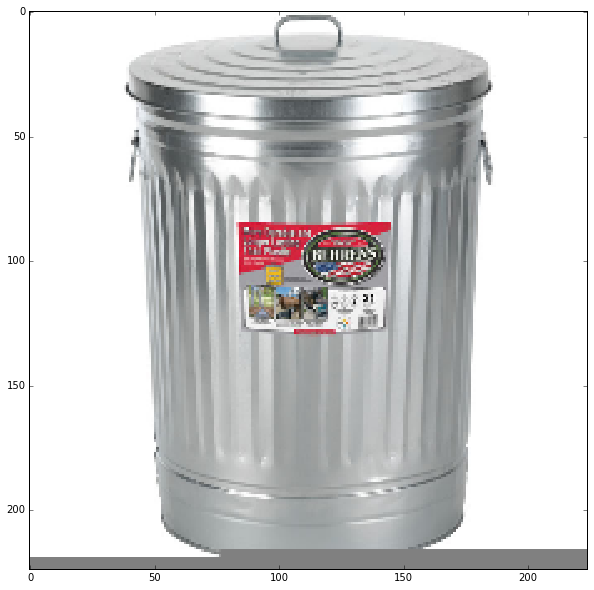

In [89]:
garbage_url = 'http://www.behrensmfg.com/wp-content/uploads/1270-31-gallon-trash-can.jpg'
classify(garbage_url)
garbage_data = np.copy(net.blobs['data'].data)

/tmp/tmpkBnSNl.png
Predicted class is #623.
['n03658185 letter opener, paper knife, paperknife' 'n04141327 scabbard'
 'n03804744 nail' 'n04376876 syringe' 'n04090263 rifle']


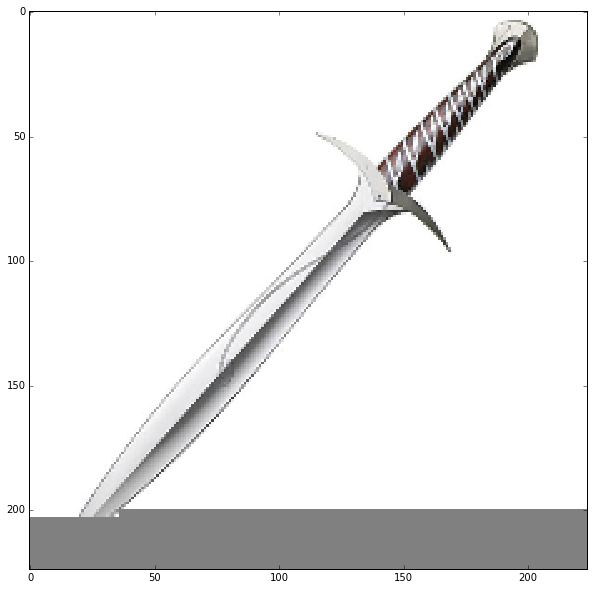

In [25]:
sword_url = 'http://a.tgcdn.net/images/products/zoom/f2bc_sting_the_sword_of_bilbo_baggins.jpg'
classify(sword_url)
sword_data = np.copy(net.blobs['data'].data)

/tmp/tmpNuEsRl.png
Predicted class is #770.
['n04120489 running shoe' 'n03047690 clog, geta, patten, sabot'
 'n04133789 sandal' 'n03680355 Loafer'
 'n04200800 shoe shop, shoe-shop, shoe store']


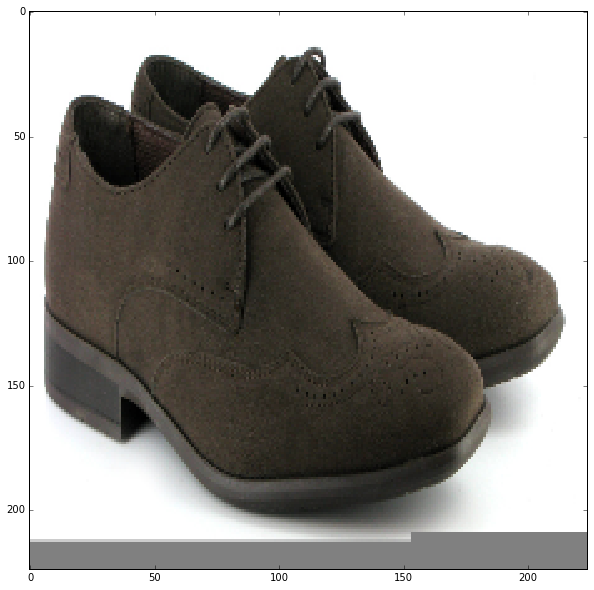

In [26]:
shoes_url = 'http://www.vegetarian-shoes.co.uk/Portals/42/product/images/prd06da61c8-f8a9-402a-8590-fbec98bfbf1a.jpg'
classify(shoes_url)
shoes_data = np.copy(net.blobs['data'].data)

/tmp/tmppaYmrO.png
Predicted class is #285.
['n02124075 Egyptian cat' 'n02123045 tabby, tabby cat'
 'n02123159 tiger cat'
 'n04553703 washbasin, handbasin, washbowl, lavabo, wash-hand basin'
 'n02127052 lynx, catamount']


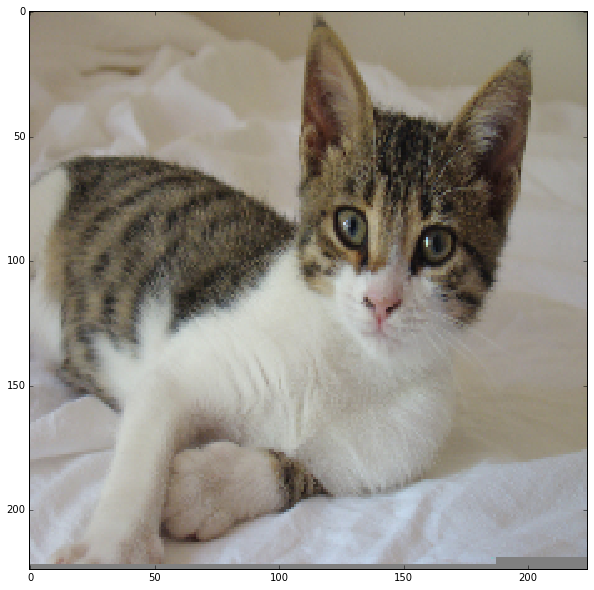

In [101]:
kitten_url = 'https://upload.wikimedia.org/wikipedia/commons/b/b9/CyprusShorthair.jpg'
classify(kitten_url)
kitten_data = np.copy(net.blobs['data'].data)

/tmp/tmpB_FwUi.png
Predicted class is #263.
['n02113023 Pembroke, Pembroke Welsh corgi' 'n02088364 beagle'
 'n02113186 Cardigan, Cardigan Welsh corgi' 'n02099601 golden retriever'
 'n02085620 Chihuahua']


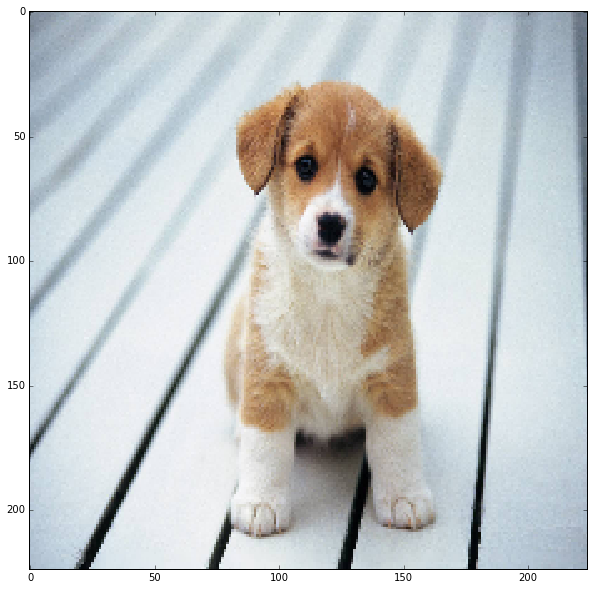

In [82]:
dog_url = 'http://cdn.playbuzz.com/cdn/7820ec56-cd7d-487c-87ba-30ca87219dc4/26084bf6-4235-4f8f-9c2f-b7294ea62c15.jpg'
classify(dog_url)
dog_data = np.copy(net.blobs['data'].data)

/tmp/tmpVG6Q2R.png
Predicted class is #793.
['n04209133 shower cap' 'n02869837 bonnet, poke bonnet' 'n04584207 wig'
 'n02807133 bathing cap, swimming cap'
 'n03485794 handkerchief, hankie, hanky, hankey']


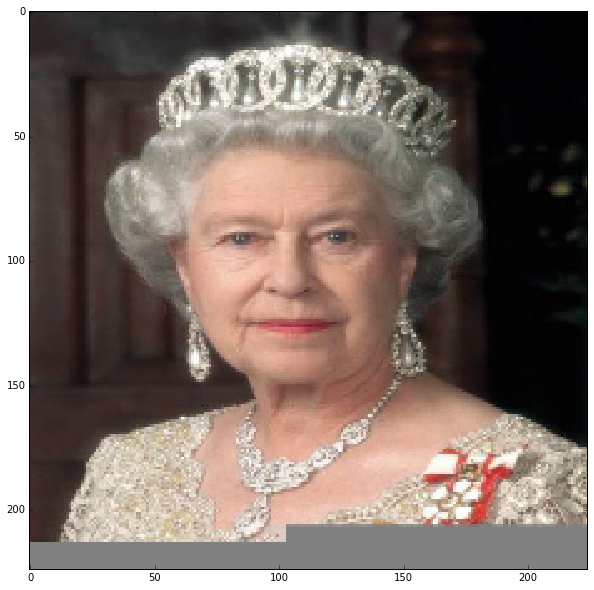

In [28]:
queen_url = 'http://www.librarising.com/astrology/celebs/images2/QR/queenelizabethii.jpg'
classify(queen_url)

/tmp/tmp0QDz3k.png
Predicted class is #716.
['n03930313 picket fence, paling'
 'n04604644 worm fence, snake fence, snake-rail fence, Virginia fence'
 'n03733281 maze, labyrinth' 'n04040759 radiator' 'n04532670 viaduct']


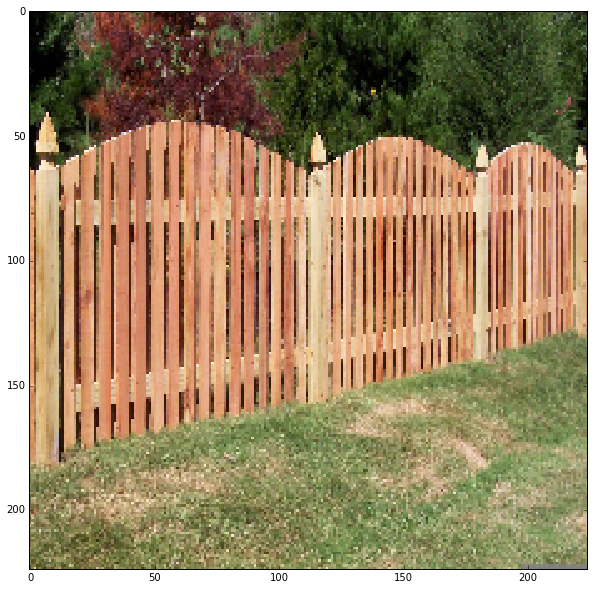

In [29]:
fence_url = 'http://jmarvinhandyman.com/wp-content/uploads/2014/04/fence-mossy-oak-wood-shadowbox_1373304.jpg'
classify(fence_url)
fence_data = np.copy(net.blobs['data'].data)

In [103]:
def derivative(net):
    desired_output = np.zeros_like(net.blobs['prob'].data)
    for i in range(10):
        desired_output[i][793] = 1
    return net.backward(**{net.outputs[0]: desired_output})

In [106]:
net.blobs['prob'].data.shape

(10, 1000)

In [68]:
labels

array(['n01440764 tench, Tinca tinca',
       'n01443537 goldfish, Carassius auratus',
       'n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
       'n01491361 tiger shark, Galeocerdo cuvieri',
       'n01494475 hammerhead, hammerhead shark',
       'n01496331 electric ray, crampfish, numbfish, torpedo',
       'n01498041 stingray', 'n01514668 cock', 'n01514859 hen',
       'n01518878 ostrich, Struthio camelus',
       'n01530575 brambling, Fringilla montifringilla',
       'n01531178 goldfinch, Carduelis carduelis',
       'n01532829 house finch, linnet, Carpodacus mexicanus',
       'n01534433 junco, snowbird',
       'n01537544 indigo bunting, indigo finch, indigo bird, Passerina cyanea',
       'n01558993 robin, American robin, Turdus migratorius',
       'n01560419 bulbul', 'n01580077 jay', 'n01582220 magpie',
       'n01592084 chickadee', 'n01601694 water ouzel, dipper',
       'n01608432 kite',
       'n01614925 bald eagle, Americ

In [90]:
push_layer = 'prob'
push_idx = 716
print labels[push_idx]
push_dir = 1
diffs = net.blobs[push_layer].diff * 0
diffs[0][push_idx] = push_dir
#backout = net.backward_from_layer('prob', diffs)
backout = net.backward(prob=diffs)
grad = backout['data'].copy()

n03930313 picket fence, paling


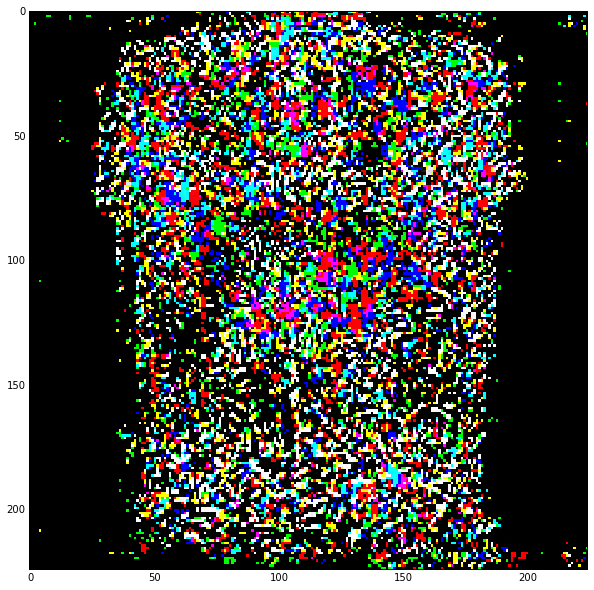

In [91]:
plt.imshow(transformer.deprocess('data', grad[0] *  1 / np.percentile(grad, 98)))


class: 412, label: n02747177 ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin, certainty: 0.405762076378


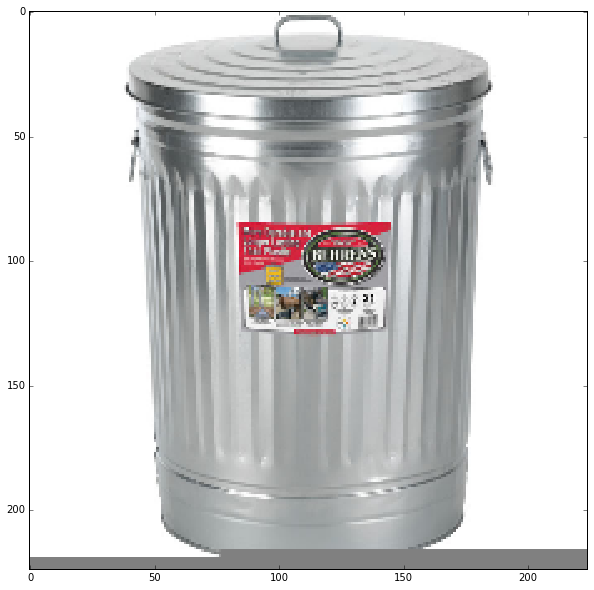

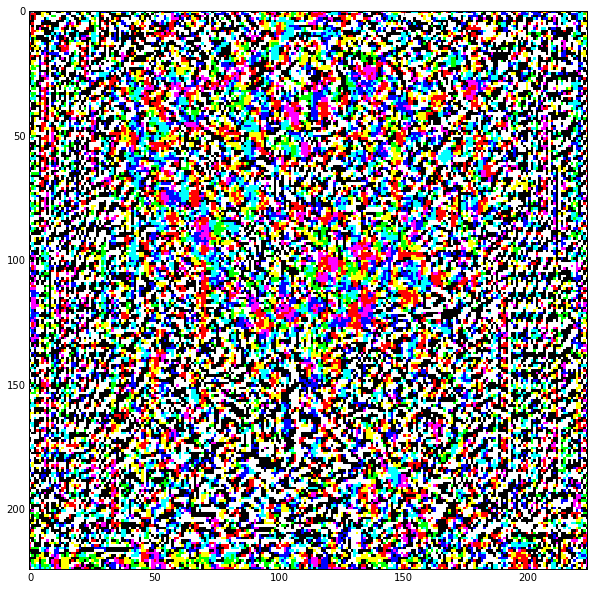

In [94]:
sign = np.sign(grad)
net.blobs['data'].data[...] = garbage_data + 0 * sign
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))
plt.figure()
plt.imshow(transformer.deprocess('data', sign[0]))
out = net.forward()['prob'][0]
prediction = out.argmax()
top_k = out.argsort()[-1:-6:-1]
for pred in top_k[:1]:
    print "class: {cls}, label: {label}, certainty: {certainty}".format(
        cls=pred, label=labels[pred], certainty=out[pred])
#print labels[prediction]
#print 'certainty', out['prob'][0][prediction]


Helper functions for visualization

In [69]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

The input image

The first layer filters, `conv1`

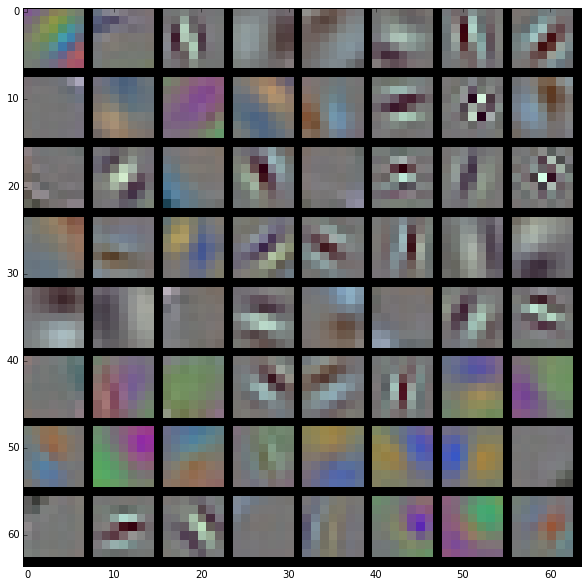

In [70]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1/7x7_s2'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

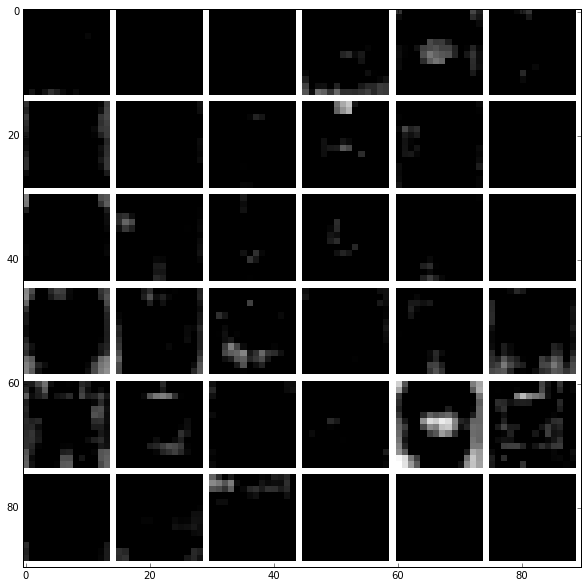

In [71]:
feat = net.blobs['inception_4a/pool_proj'].data[0, :36]
vis_square(feat, padval=1)

The second layer filters, `conv2`

There are 256 filters, each of which has dimension 5 x 5 x 48. We show only the first 48 filters, with each channel shown separately, so that each filter is a row.

In [74]:
filters = net.params['conv2'][0].data
vis_square(filters[:48].reshape(48**2, 5, 5))

KeyError: 'conv2'

The second layer output, `conv2` (rectified, only the first 36 of 256 channels)

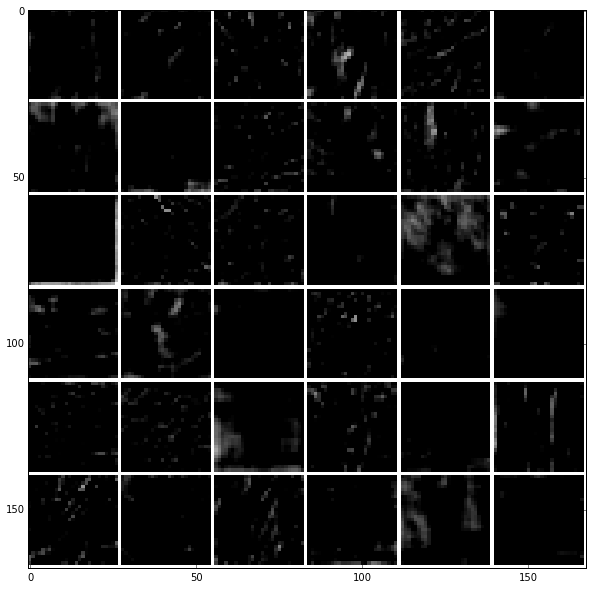

In [31]:
feat = net.blobs['conv2'].data[0, :36]
vis_square(feat, padval=1)

The third layer output, `conv3` (rectified, all 384 channels)

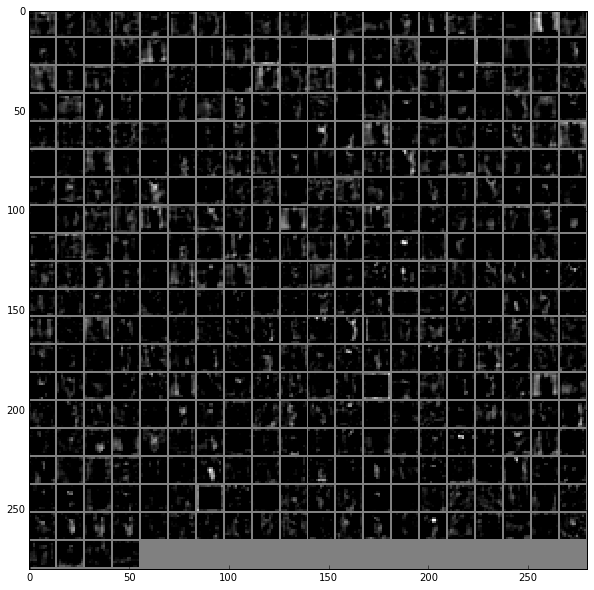

In [32]:
feat = net.blobs['conv3'].data[0]
vis_square(feat, padval=0.5)

The fourth layer output, `conv4` (rectified, all 384 channels)

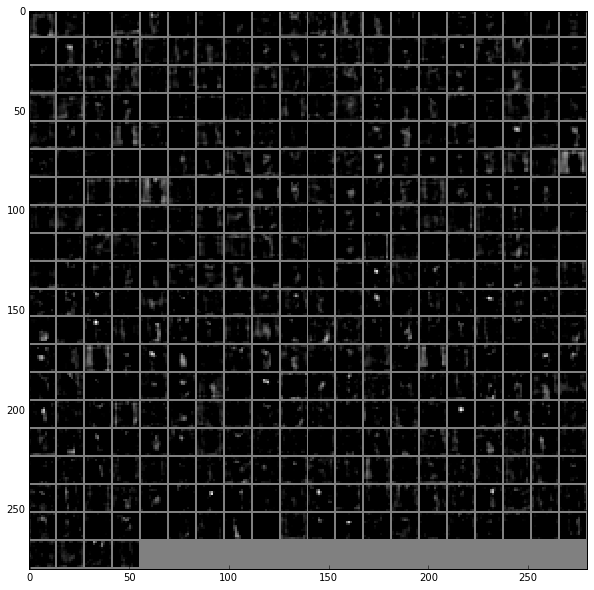

In [33]:
feat = net.blobs['conv4'].data[0]
vis_square(feat, padval=0.5)

The fifth layer output, `conv5` (rectified, all 256 channels)

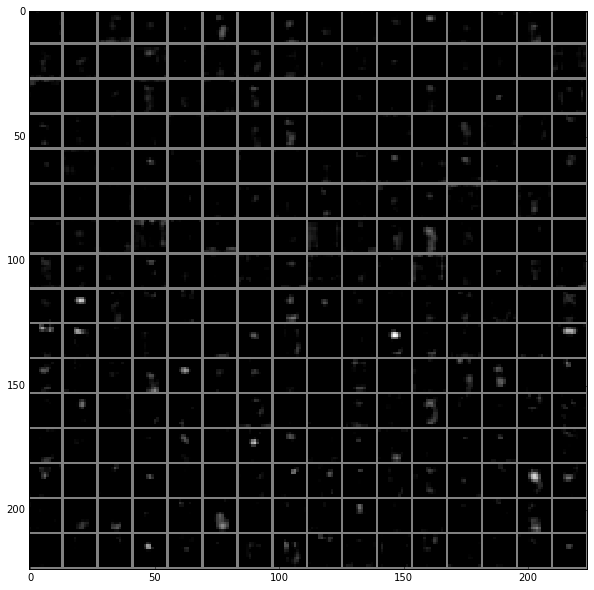

In [34]:
feat = net.blobs['conv5'].data[0]
vis_square(feat, padval=0.5)

The fifth layer after pooling, `pool5`

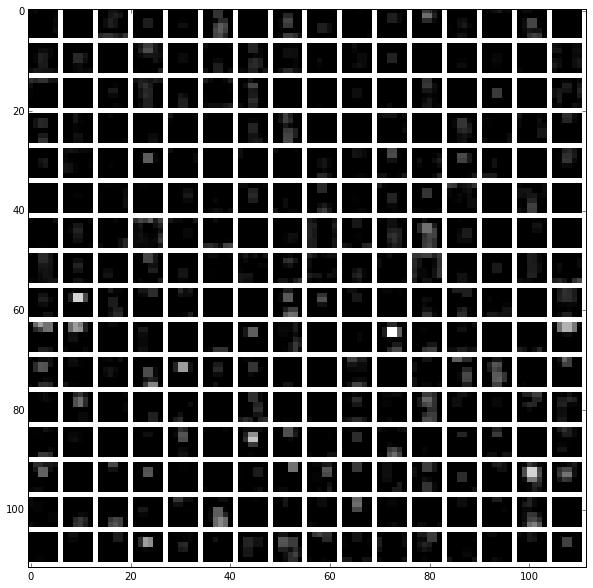

In [35]:
feat = net.blobs['pool5'].data[0]
vis_square(feat, padval=1)

The first fully connected layer, `fc6` (rectified)

We show the output values and the histogram of the positive values